___
<center>
    <font size='10'>
        <b>
            Modélisation : recherche de clusters
        </b>
    </font>
</center>
<center>
    <font size='7'>
        <br>Partie 2    
    </font>  
</center>
 
</center>

___

> <font size='3'>
Dans cette deuxième étude, nous chercherons à identifier des groupes de clients ayant des similarités. Cela permettra à l'équipe commerciale de mieux comprendre leurs clients lors de leurs campagnes de communication.
</font>  

In [1]:
# Inline function to format code to PEP8.
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries.
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
)

from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
# Path to save images.
path = "Images/Part02/"

# Importing the RFM csv file.
rfm = pd.read_csv("RFM.csv", index_col=0)
rfm.shape

(12011, 8)

---
<center>
    <font size='7'>
        Clustering avec 3 variables
    </font>
</center>

---

# Visualisation en 2D des variables : Recency, Frequency, Monetary

In [4]:
# Preparing data for transformation with TSNE.
X3var = rfm.loc[:, ["Recency", "Frequency", "Monetary"]]

# Standard scaling of X3var.
X3scaled = StandardScaler().fit_transform(X3var)

# Réglage de l'hyperparamètre : ```Perplexity```

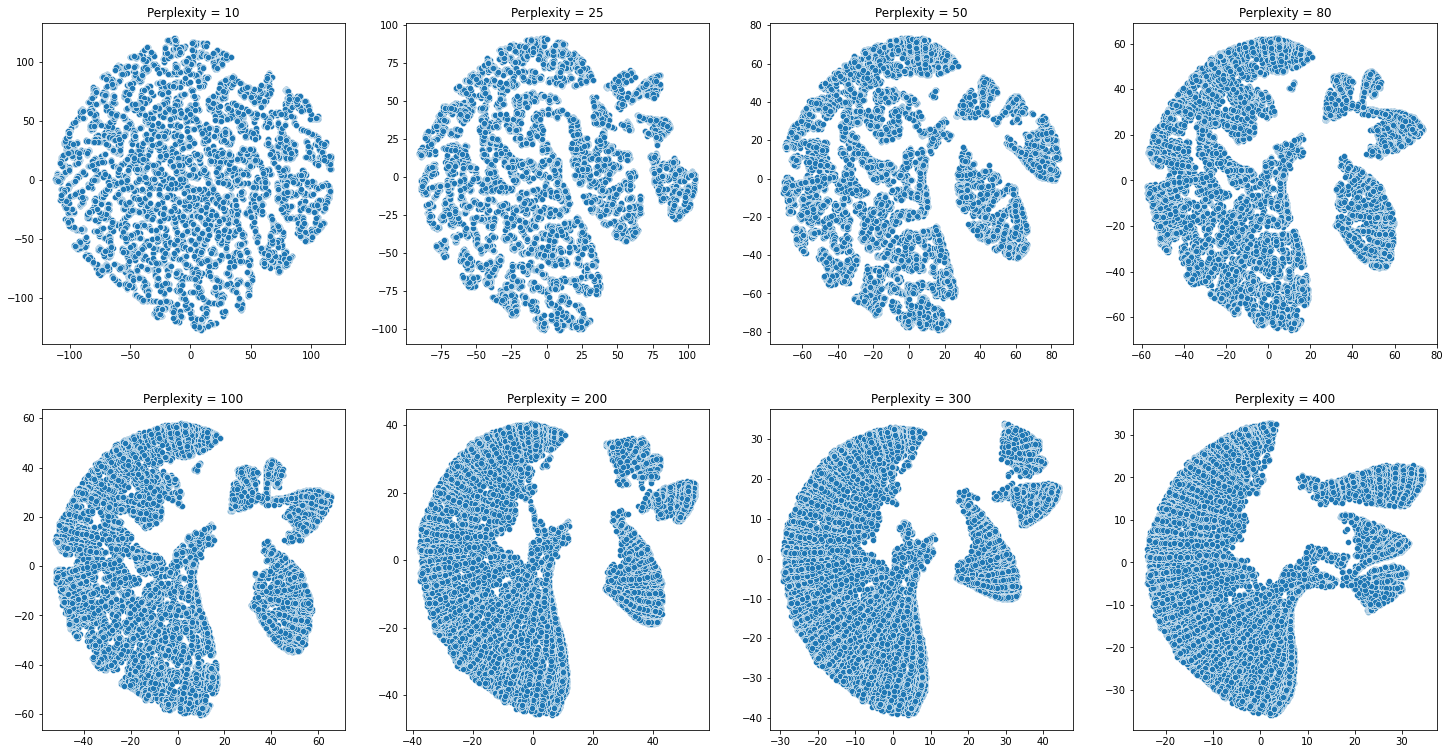

'\nfor i,pnum in enumerate(Perplexity_numbers_3vars):\n    # Transforming data using TSNE for X scaled.\n    X3tsne = TSNE(n_components=2,perplexity=pnum, learning_rate=200.0, n_iter=1000, init=\'pca\').fit_transform(X3scaled)\n    plt.figure()\n    plt.title(f\'Perplexity={pnum}\')\n    sns.scatterplot(x=X3tsne[:,0], y=X3tsne[:,1])\n    plt.xticks(rotation=\'90\');\n    plt.savefig(path + "01_PerplexityTuning_3vars.png", bbox_inches=\'tight\', facecolor=\'w\')\n'

In [5]:
# Searching for best perplexity number.
Perplexity_numbers_3vars = [10, 25, 50, 80, 100, 200, 300, 400]
X3tsne_table = []

fig, ax = plt.subplots(2, 4, figsize=(25, 13))
for j, pnum in enumerate(Perplexity_numbers_3vars[0:4]):
    X3tsne = TSNE(
        n_components=2, perplexity=pnum, learning_rate=200.0, n_iter=1000, init="pca"
    ).fit_transform(X3scaled)
    # fig.suptitle(f'Perplexity Tuning')
    ax[0, j].set_title(f"Perplexity = {pnum}")
    sns.scatterplot(x=X3tsne[:, 0], y=X3tsne[:, 1], ax=ax[0, j])

for j, pnum in enumerate(Perplexity_numbers_3vars[4:]):
    X3tsne = TSNE(
        n_components=2, perplexity=pnum, learning_rate=200.0, n_iter=1000, init="pca"
    ).fit_transform(X3scaled)
    ax[1, j].set_title(f"Perplexity = {pnum}")
    sns.scatterplot(x=X3tsne[:, 0], y=X3tsne[:, 1], ax=ax[1, j])

plt.savefig(path + "01_PerplexityTuning_3vars.png", bbox_inches="tight", facecolor="w")
plt.show()

"""
for i,pnum in enumerate(Perplexity_numbers_3vars):
    # Transforming data using TSNE for X scaled.
    X3tsne = TSNE(n_components=2,perplexity=pnum, learning_rate=200.0, n_iter=1000, init='pca').fit_transform(X3scaled)
    plt.figure()
    plt.title(f'Perplexity={pnum}')
    sns.scatterplot(x=X3tsne[:,0], y=X3tsne[:,1])
    plt.xticks(rotation='90');
    plt.savefig(path + "01_PerplexityTuning_3vars.png", bbox_inches='tight', facecolor='w')
"""

La visualisation la plus intéressante est obtenue pour l'hyperparamètre: ```Perplexity = 300```.

# Répartition des variables dans les clusters

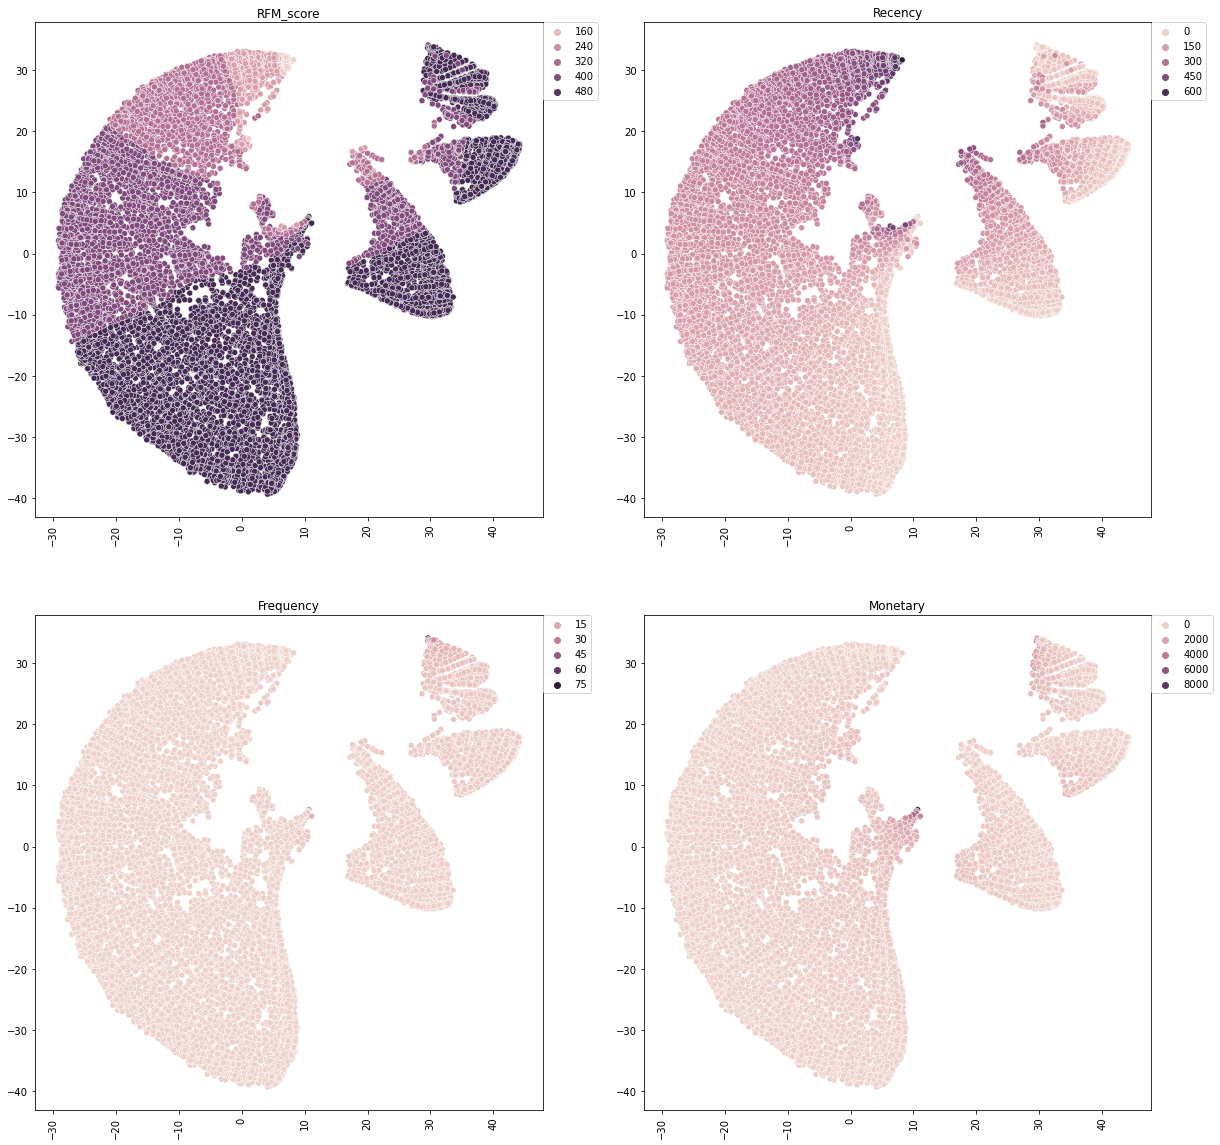

In [6]:
# Transforming data using TSNE for X scaled.
X3tsne = TSNE(
    n_components=2, perplexity=300, learning_rate=200.0, n_iter=1000, init="pca"
).fit_transform(X3scaled)

# TSNE plot.
plt.figure(figsize=(20, 20))
for n_plot, feature in enumerate(["RFM_score", "Recency", "Frequency", "Monetary"]):
    plt.subplot(2, 2, n_plot + 1)
    plt.title(feature)
    sns.scatterplot(x=X3tsne[:, 0], y=X3tsne[:, 1], hue=rfm.loc[:, feature])
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
    plt.xticks(rotation="90")
    plt.savefig(path + "02_Distribution_3vars.png", bbox_inches="tight", facecolor="w")

Les images ci-dessus nous indique que le _RFM score_ est ce qui varie le plus parmi les clients et deuxièmement c'est la variable _Recency_. Les variables Frequency et Monetary ne varient pas beaucoup. L'image présentant la variation du _RFM score_ cependant montre qu'il y a des groupes de clients ayant les mêmes scores ne sont pas séparés. Nous nous doutons donc dès maintenant que nous n'aurons pas des clusters avec des caractéristiques spécifiques par groupe.

Nous allons maintenant effectuer le clustering avec trois méthodes : Agglomerative Clustering, K-Means et DBSCAN.

Nous calculerons les scores de Silhouette pour les comparées.

# Agglomerative Clustering
Pour cette méthode, nous commençons par visualiser le dendrogram, ensuite nous chosissons le nombre de clusters que nous souhaitons avoir. La droite verticale en pointillée noire indique le nombre de cluster. Ici ce sera 4, ce qui correspond à ce qu'on peut visualiser avec T-SNE.

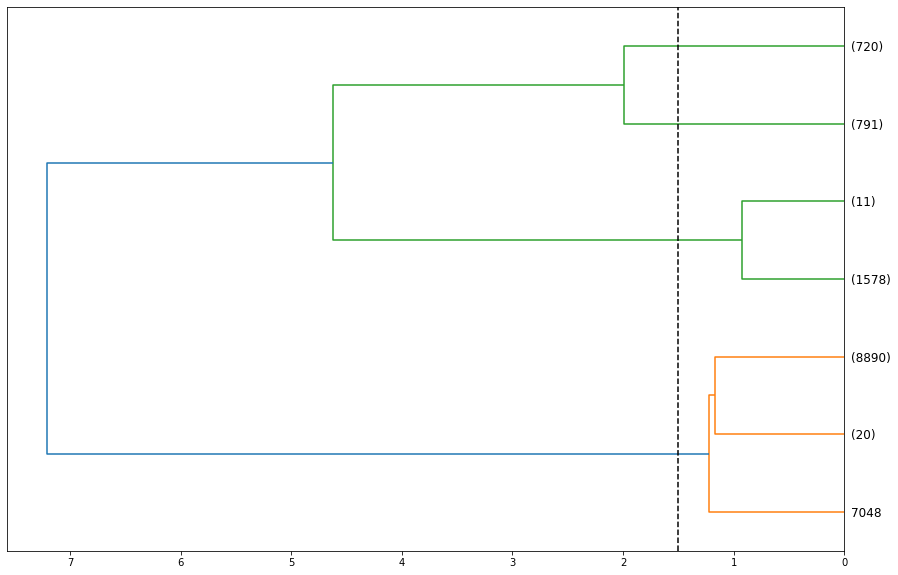

In [7]:
# Plotting the dendrogram.
plt.figure(figsize=(15, 10))
dendrogram(
    linkage(X3tsne, method="single"), truncate_mode="level", p=2, orientation="left"
)
plt.vlines(x=1.5, ymin=0, ymax=100, linestyles="dashed", color="black")
plt.savefig(path + "03_Hierarchical_dendrogram.png", bbox_inches="tight", facecolor="w")

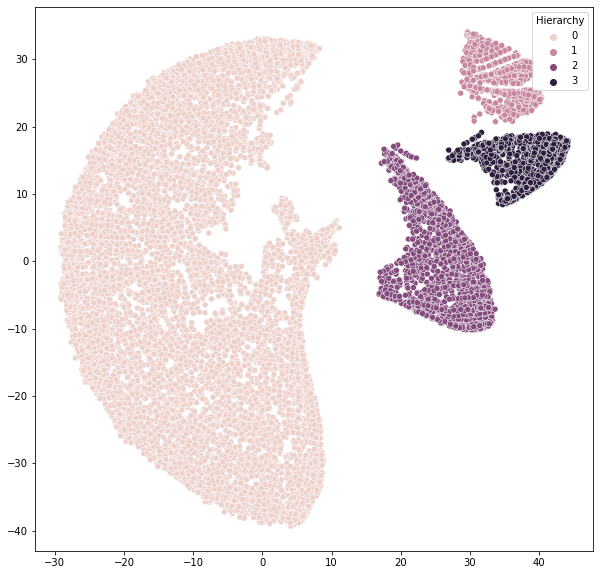

In [8]:
# Clustering using Agglomerative Clustering with number of clusters given above on the dendrogram.
X3var["Hierarchy"] = AgglomerativeClustering(
    n_clusters=4, linkage="single"
).fit_predict(X3tsne)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=X3tsne[:, 0], y=X3tsne[:, 1], hue=X3var.loc[:, "Hierarchy"])
plt.savefig(path + "04_Hierarchical_plot_3vars.png", bbox_inches="tight", facecolor="w")

In [9]:
silhouette_score(X3tsne, labels=X3var.Hierarchy, metric="euclidean")

0.33856827

Malgré le fait que les clusters ont l'air d'être bien séparé, le score de silhouette est faible. Cela est cohérent avec l'observation précédente avec la répartition du _RFM score_.

# KMeans Clustering

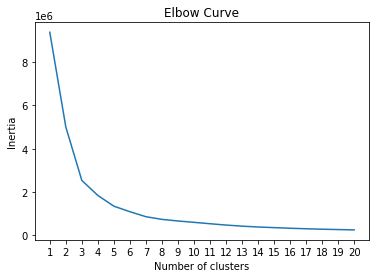

In [10]:
# Standard scaling.
x_var = X3tsne[:, 0]
y_var = X3tsne[:, 1]

# Elbow curve.
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X3tsne)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.title("Elbow Curve")
plt.plot(range(1, 21), wcss)
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.savefig(path + "05_KMeans_ElbowCurve.png", bbox_inches="tight", facecolor="w")

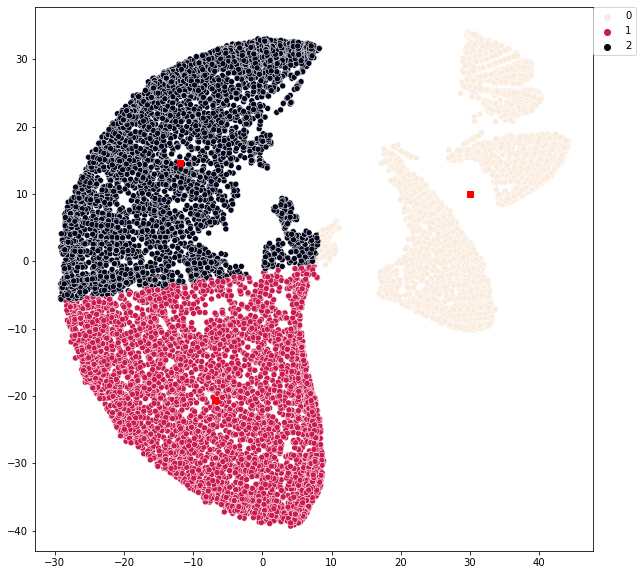

In [11]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X3tsne)
clusters_km3 = []
clusters_km3 = kmeans.predict(X3tsne)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=x_var, y=y_var, hue=clusters_km3, palette="rocket_r")
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="r", marker="s"
)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.savefig(path + "06_KMeans_Clusters.png", bbox_inches="tight", facecolor="w")

In [12]:
#  Calculating Silhouette score
silhouette_score(X3tsne, clusters_km3, metric="euclidean")

0.50152576

Nous observons que l'algorithme de K-Means n'arrive pas à identifier les clusters présents. Le plus grand cluster est divisé en deux, alors que visuellement nous n'observons pas de séparation. Cependant, le Silhouette Score est de environ $0.50$, ce qui est un meilleur score que précédemment. Cela confirme d'avantage que les clients ne sont pas bien séparés.

---
# DBSCAN Clustering

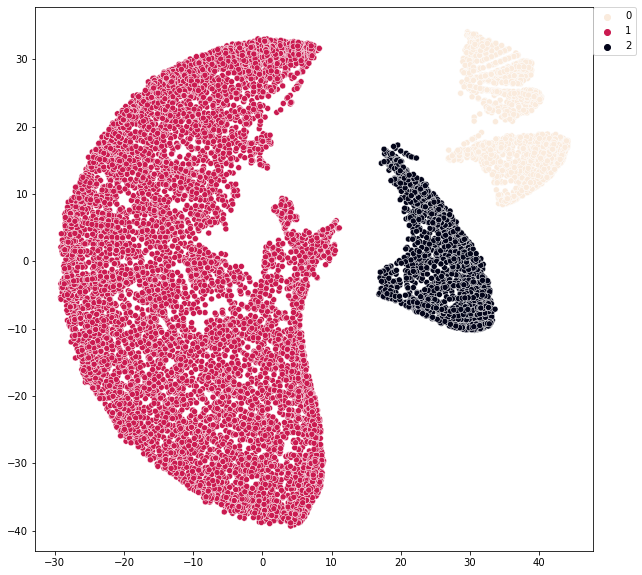

In [13]:
# Clustering using DBSCAN.
dbscan = DBSCAN(eps=4, min_samples=100)
clusters_db3 = []
clusters_db3 = dbscan.fit_predict(X3tsne)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=x_var, y=y_var, hue=clusters_db3, palette="rocket_r")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.savefig(path + "07_DBSCAN_Clusters_3vars.png", bbox_inches="tight", facecolor="w")

In [14]:
#  Calculating Silhouette score
print(f"Silhouette Score = {silhouette_score(X3tsne,clusters_db3,metric='euclidean')}")
print(f"Calinski Harabasz Score ={calinski_harabasz_score(X3tsne,clusters_db3)}")

Silhouette Score = 0.3576618432998657
Calinski Harabasz Score =5577.497511194655


L'algorithme de DBSCAN arrive à distinguer les clusters, comme l'algorithme de Agglomerative Clustering. Cependant le score de Silhouette est faible également. Nous concluouns que 3 variables ne suffisent pas pour la segmentation de clients. Puisque le _RFM score_ semble bien les distingués, nous allons le rajouter comme quatrième variable pour la segmentation clientèle.

---
---
<center>
    <font size='7'>
        Clustering avec 4 variables
    </font>
</center>

---

## Visualisation en 2D des variables : Recency, Frequency, Monetary, RFM score
Nous rajoutant la variable RFM score ici qui est donnée par $$RFM_{score} = 100\times Recency_{score}+10\times Frequency_{score}+Monetary_{score}$$

# Réglage de l'hyperparamètre : ```Perplexity```

In [15]:
# Preparing data for transformation with TSNE.
X4var = rfm.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]

# Standard scaling of X.
Xscaled = StandardScaler().fit_transform(X4var)

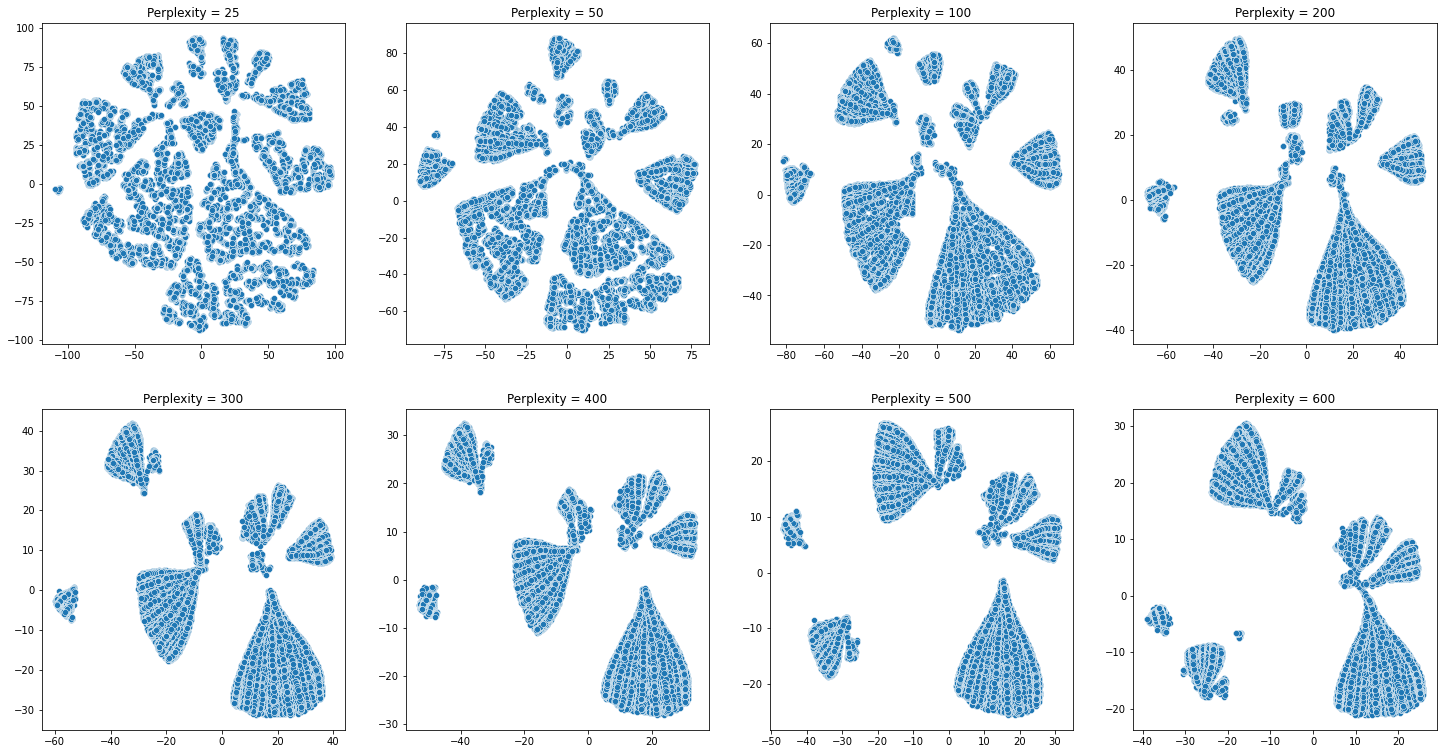

"    \nfor i,pnum in enumerate(Perplexity_numbers):\n    # Transforming data using TSNE for X scaled.\n    X4tsne = TSNE(n_components=2,perplexity=pnum, learning_rate=200.0, n_iter=1000, init='pca').fit_transform(Xscaled)\n    \n    plt.figure()\n    plt.title(f'Perplexity={pnum}')\n    sns.scatterplot(x=X4tsne[:,0], y=X4tsne[:,1])\n    plt.xticks(rotation='90');\n"

In [16]:
# Searching for best perplexity number.
Perplexity_numbers = [25, 50, 100, 200, 300, 400, 500, 600]

fig, ax = plt.subplots(2, 4, figsize=(25, 13))
for j, pnum in enumerate(Perplexity_numbers[0:4]):
    Xtsne = TSNE(
        n_components=2, perplexity=pnum, learning_rate=200.0, n_iter=1000, init="pca"
    ).fit_transform(Xscaled)
    ax[0, j].set_title(f"Perplexity = {pnum}")
    sns.scatterplot(x=Xtsne[:, 0], y=Xtsne[:, 1], ax=ax[0, j])

for j, pnum in enumerate(Perplexity_numbers[4:]):
    Xtsne = TSNE(
        n_components=2, perplexity=pnum, learning_rate=200.0, n_iter=1000, init="pca"
    ).fit_transform(Xscaled)
    ax[1, j].set_title(f"Perplexity = {pnum}")
    sns.scatterplot(x=Xtsne[:, 0], y=Xtsne[:, 1], ax=ax[1, j])

plt.savefig(path + "08_PerplexityTuning_4vars.png", bbox_inches="tight", facecolor="w")
plt.show()
"""    
for i,pnum in enumerate(Perplexity_numbers):
    # Transforming data using TSNE for X scaled.
    X4tsne = TSNE(n_components=2,perplexity=pnum, learning_rate=200.0, n_iter=1000, init='pca').fit_transform(Xscaled)
    
    plt.figure()
    plt.title(f'Perplexity={pnum}')
    sns.scatterplot(x=X4tsne[:,0], y=X4tsne[:,1])
    plt.xticks(rotation='90');
"""

# Sélection des variables à utiliser
En rajoutant la variable ```RFM score```, la séparation des clusters est plus net avec l'hyperparamètre ```perplexity = 200```.

In [17]:
# Transforming data using TSNE for X scaled.
Xtsne = TSNE(
    n_components=2, perplexity=500, learning_rate=200.0, n_iter=1000, init="pca"
).fit_transform(Xscaled)

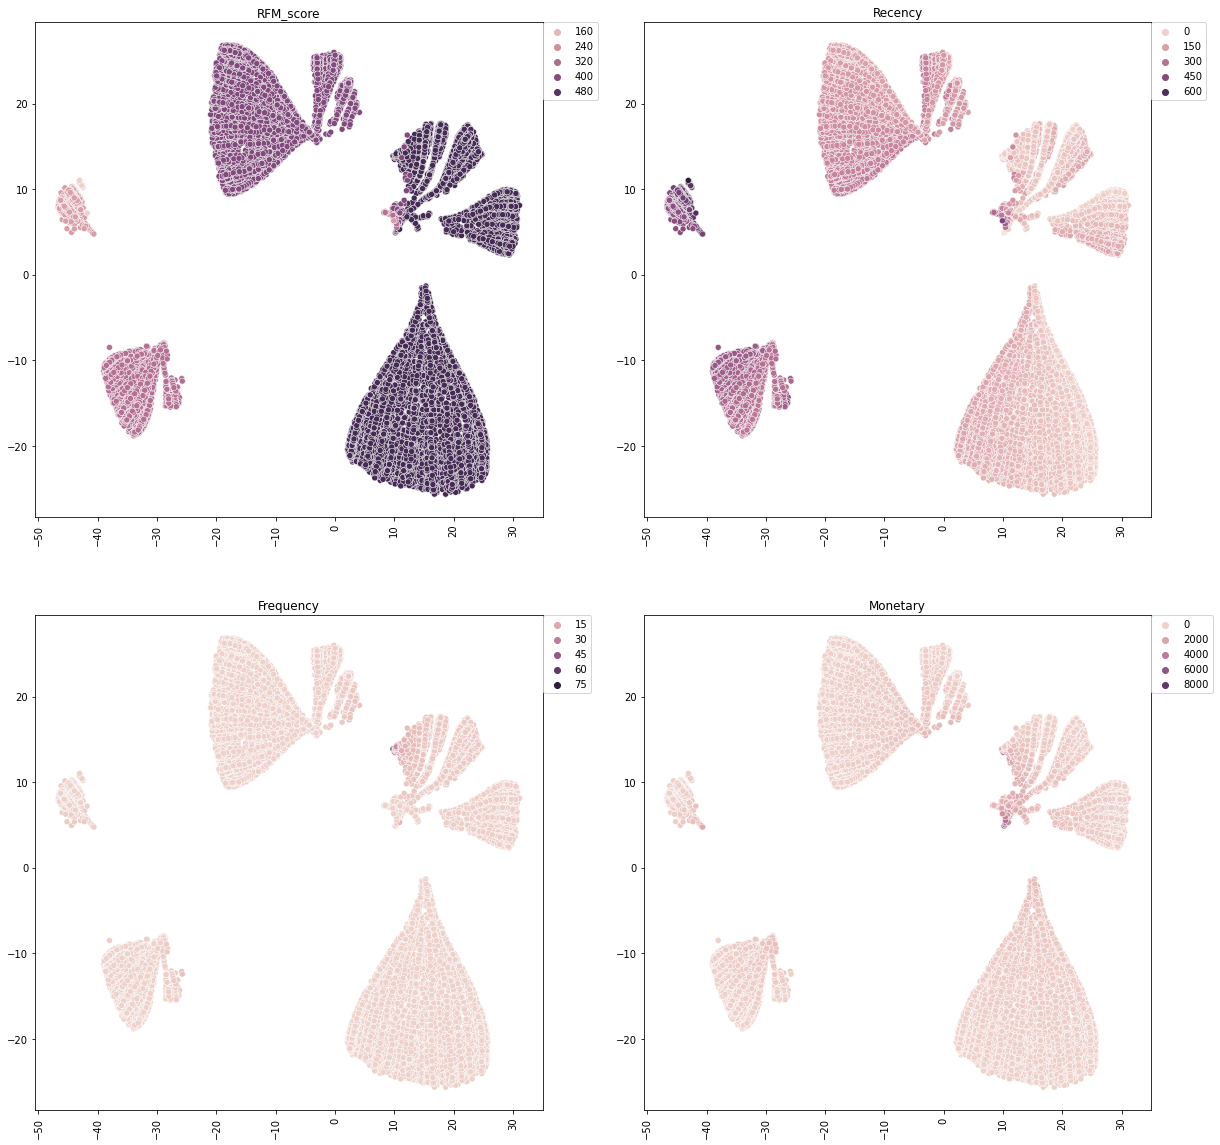

In [18]:
# TSNE plot.
plt.figure(figsize=(20, 20))
for n_plot, feature in enumerate(["RFM_score", "Recency", "Frequency", "Monetary"]):
    plt.subplot(2, 2, n_plot + 1)
    plt.title(feature)
    sns.scatterplot(x=Xtsne[:, 0], y=Xtsne[:, 1], hue=rfm.loc[:, feature])
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
    plt.xticks(rotation="90")
plt.savefig(path + "08_RFM_plots_4vars.png", bbox_inches="tight", facecolor="w")

Sur la figure en haut à gauche, nous constatons que le score RFM et la Récence sont assez bien réparti entre les clusters. Pour la Fréquence, nous observons moins cette répartition, car très peu de clients se distinguent vraiment en terme de fidélité, la majorité ont fait 2 achats seulement. Concernant les dépenses (Monetary), c'est la même chose, nous n'observons pas de grandes variations, car la majorité des clients ont dépensé peu, et seul un faible pourcentage a dépensé de grosses sommes d'argent.

Passons maintenant au clustering et comparons les différentes méthodes avec les scores de Silhouette et de Calinski-Harabasz.

# Hierarchical clustering

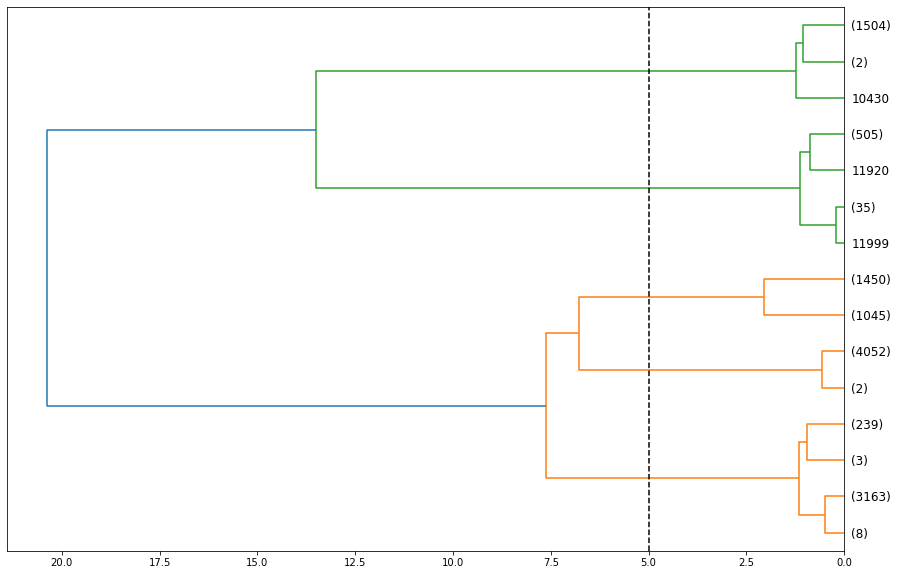

In [19]:
# Plotting the dendrogram.
plt.figure(figsize=(15, 10))
dendrogram(
    linkage(Xtsne, method="single"), truncate_mode="level", p=3, orientation="left"
)
plt.vlines(x=5, ymin=0, ymax=150, linestyles="dashed", color="black")
plt.savefig(path + "09_Dendrogram_4vars.png", bbox_inches="tight", facecolor="w")

Silhouette Score = 0.6668328642845154
Calinski Harabasz Score =35621.73264891524


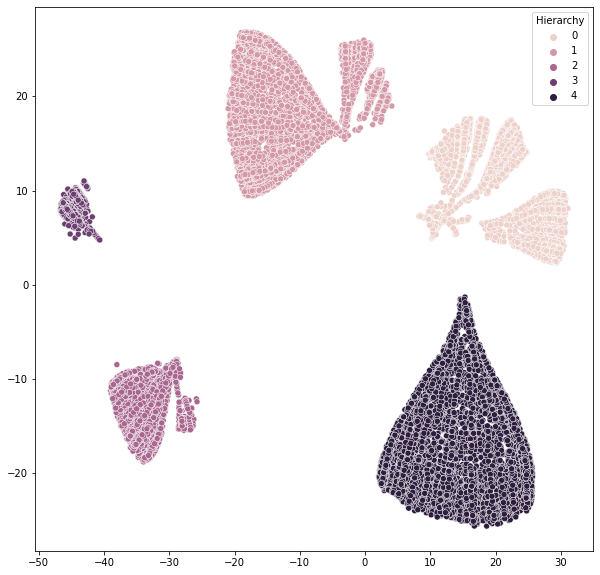

In [20]:
# Agglomerative clustering.
X4var["Hierarchy"] = AgglomerativeClustering(
    n_clusters=5, linkage="single"
).fit_predict(Xtsne)

# Recording in rfm
rfm["cluster_hierarchy"] = X4var["Hierarchy"]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=Xtsne[:, 0], y=Xtsne[:, 1], hue=X4var.loc[:, "Hierarchy"])
plt.savefig(path + "10_Hierarchy_4vars.png", bbox_inches="tight", facecolor="w")


#  Calculating Silhouette score
print(
    f"Silhouette Score = {silhouette_score(Xtsne,X4var['Hierarchy'],metric='euclidean')}"
)
print(f"Calinski Harabasz Score ={calinski_harabasz_score(Xtsne,X4var['Hierarchy'])}")

---

# K-Means Clustering

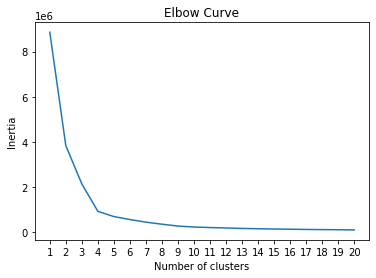

In [21]:
# Standard scaling.
xvar = Xtsne[:, 0]
yvar = Xtsne[:, 1]

# Elbow curve to determine best number of clusters.
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(Xtsne)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve.
plt.figure()
plt.title("Elbow Curve")
plt.plot(range(1, 21), wcss)
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.savefig(path + "11_KMeans_ElbowCurve_4vars.png", bbox_inches="tight", facecolor="w")

Grâce au _Elbow Curve_, nous voyons que nous pouvons prendre un nombre de cluster, ```n_clusters=4```.

Silhouette Score = 0.6471220850944519
Calinski Harabasz Score =34540.886778756016


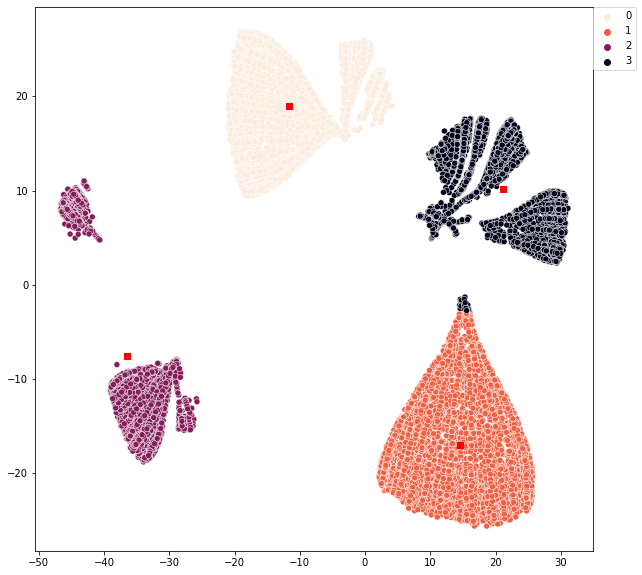

In [22]:
# Clustering with KMeans.
kmeans = KMeans(n_clusters=4, random_state=2)
kmeans.fit(Xtsne)
clusters_km4 = []
clusters_km4 = kmeans.predict(Xtsne)

# Recording in rfm.
rfm["cluster_kmeans"] = clusters_km4

# Plotting the clusters
plt.figure(figsize=(10, 10))
sns.scatterplot(x=xvar, y=yvar, hue=clusters_km4, palette="rocket_r")
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="r", marker="s"
)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.savefig(path + "12_KMeans_Plot_4vars.png", bbox_inches="tight", facecolor="w")

#  Calculating Silhouette score
print(f"Silhouette Score = {silhouette_score(Xtsne,clusters_km4,metric='euclidean')}")
print(f"Calinski Harabasz Score ={calinski_harabasz_score(Xtsne,clusters_km4)}")

---

# DBSCAN

Silhouette Score = 0.6668328642845154
Calinski Harabasz Score =35621.73264891524


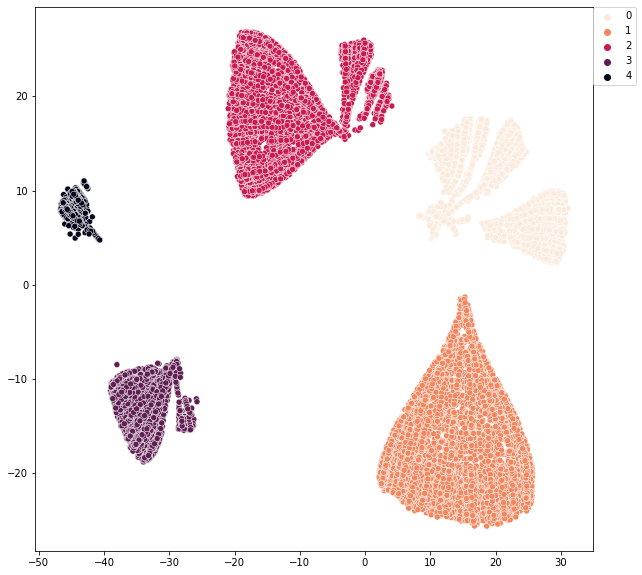

In [23]:
# Clustering using DBSCAN.
dbscan = DBSCAN(eps=3, min_samples=10)
# clusters_db4 =[]
rfm["cluster_dbscan"] = dbscan.fit_predict(Xtsne)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=xvar, y=yvar, hue=rfm["cluster_dbscan"], palette="rocket_r")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.savefig(path + "13_DBSCAN_4vars.png", bbox_inches="tight", facecolor="w")

#  Calculating Silhouette score
print(
    f"Silhouette Score = {silhouette_score(Xtsne, rfm['cluster_dbscan'], metric='euclidean')}"
)
print(
    f"Calinski Harabasz Score ={calinski_harabasz_score(Xtsne,rfm.loc[:,'cluster_dbscan'])}"
)

# Comparaison des scores des trois modèles

In [24]:
# Selecting best clusters.
quality_of_clusters = []
for clusters in [X4var["Hierarchy"], clusters_km4, rfm["cluster_dbscan"]]:
    quality_of_clusters.append(
        [silhouette_score(Xtsne, clusters), calinski_harabasz_score(Xtsne, clusters)]
    )

# Converting to dataframe
quality_of_clusters = pd.DataFrame(
    quality_of_clusters,
    index=["Agglomerative", "KMeans", "DBSCAN"],
    columns=["Silhouette Score", "Calinski Harabasz Score"],
)

# Showing the dataframe.
quality_of_clusters

Silhouette Score  Calinski Harabasz Score
Agglomerative          0.666833             35621.732649
KMeans                 0.647122             34540.886779
DBSCAN                 0.666833             35621.732649

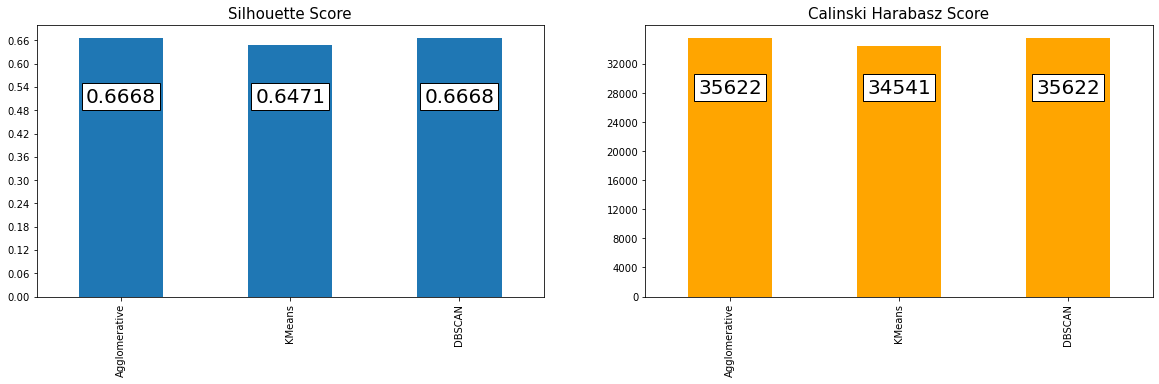

In [25]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Silhouette Score", fontsize=15)
quality_of_clusters.loc[:, "Silhouette Score"].plot.bar()
plt.yticks(np.arange(0, quality_of_clusters.loc[:, "Silhouette Score"].max(), 0.06))
for i, index in enumerate(quality_of_clusters.index):
    plt.text(
        x=i,
        y=0.50,
        s=f"{quality_of_clusters.loc[index,'Silhouette Score']:.4f}",
        ha="center",
        fontsize=20,
        bbox=dict(facecolor="white"),
    )
plt.savefig(path + "14_Silhouette_4vars.png", bbox_inches="tight", facecolor="w")

plt.subplot(1, 2, 2)
plt.title("Calinski Harabasz Score", fontsize=15)
quality_of_clusters.loc[:, "Calinski Harabasz Score"].plot.bar(color="orange")
plt.yticks(
    np.arange(0, quality_of_clusters.loc[:, "Calinski Harabasz Score"].max(), 4000)
)
for i, index in enumerate(quality_of_clusters.index):
    plt.text(
        x=i,
        y=28000,
        s=f"{quality_of_clusters.loc[index,'Calinski Harabasz Score']:.0f}",
        ha="center",
        fontsize=20,
        bbox=dict(facecolor="white"),
    )
plt.savefig(path + "15_Calinski_4vars.png", bbox_inches="tight", facecolor="w")

# Particularité des clusters
Nous obtenons six groupes de clients. Regardons de plus prêt les liens entre eux.

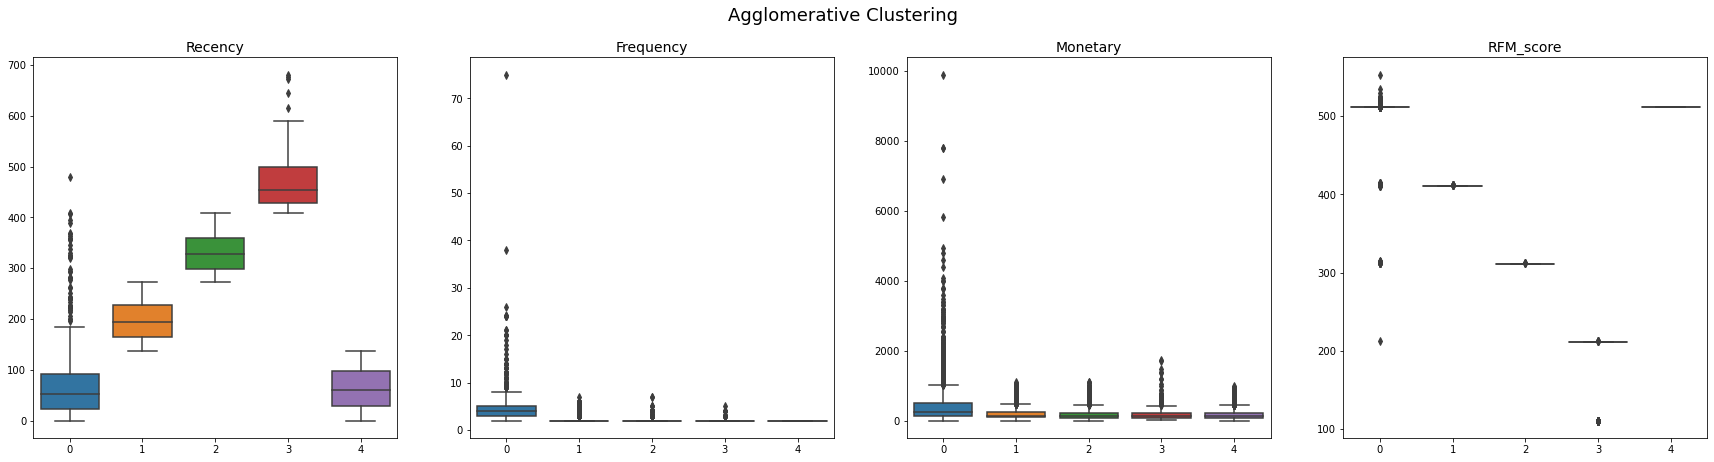

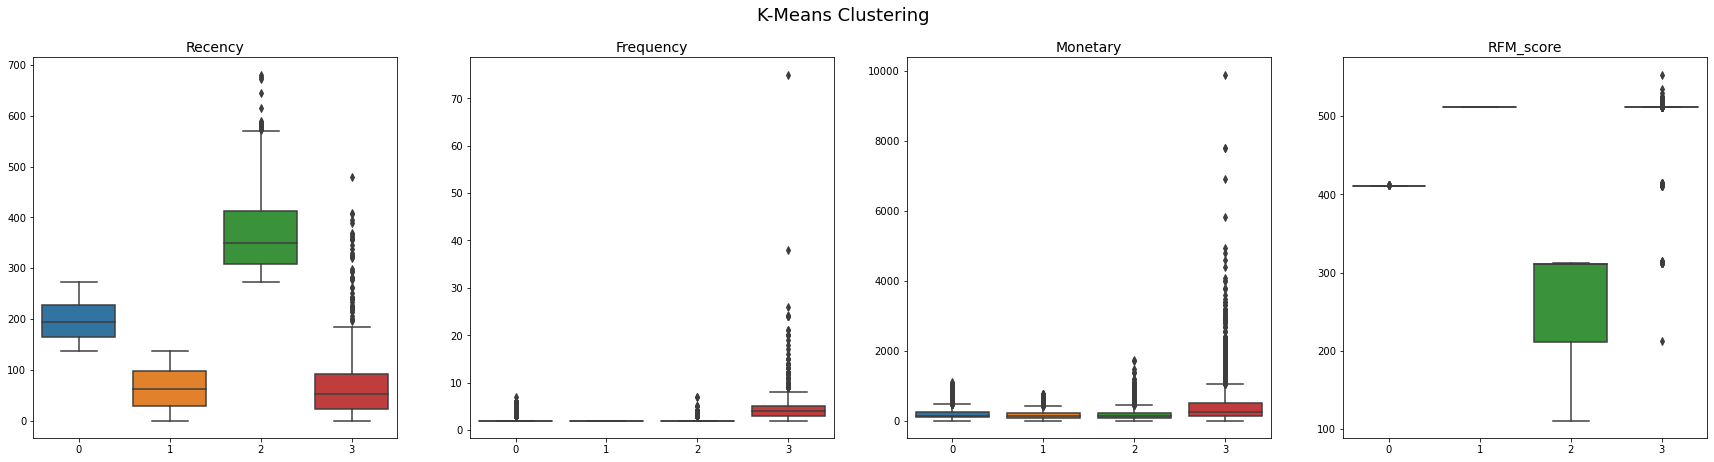

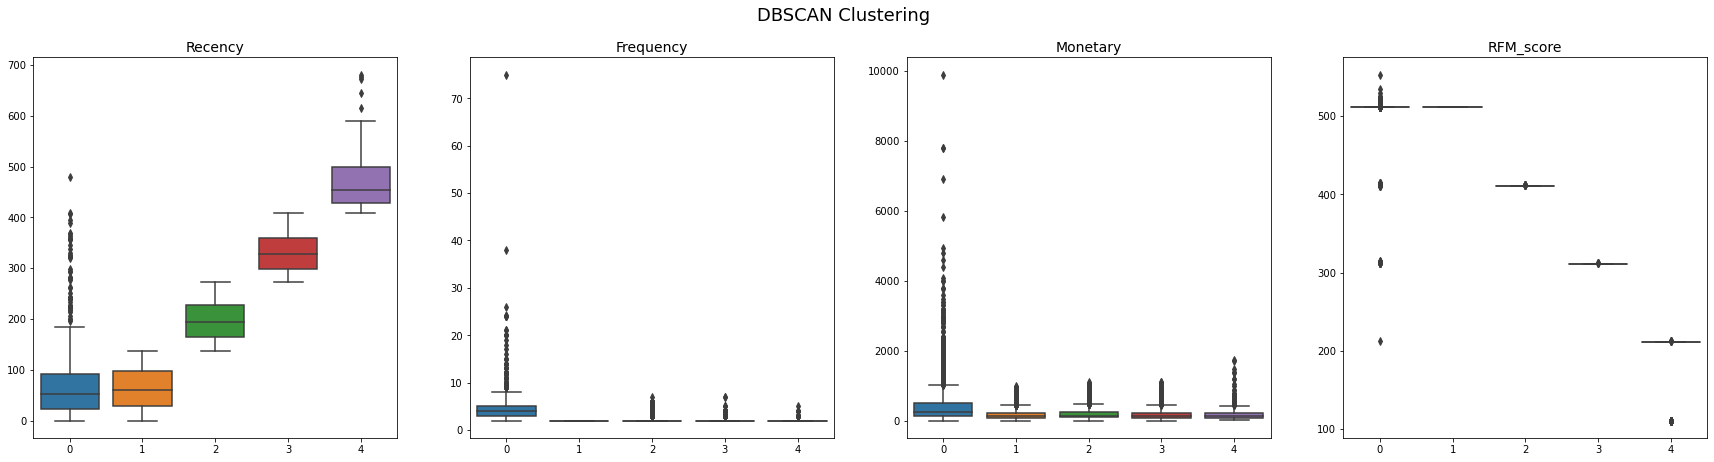

In [26]:
rfm_scaled = pd.DataFrame(Xscaled, columns=X4var.columns[0:4])
rfm_scaled["cluster_dbscan"] = rfm["cluster_dbscan"]
rfm_scaled["cluster_kmeans"] = rfm["cluster_kmeans"]
rfm_scaled["cluster_hierarchy"] = X4var["Hierarchy"]

for k, (cluster_method, cluster_titles) in enumerate(
    zip(
        ["cluster_hierarchy", "cluster_kmeans", "cluster_dbscan"],
        ["Agglomerative Clustering", "K-Means Clustering", "DBSCAN Clustering"],
    )
):
    fig, ax = plt.subplots(1, 4, figsize=(30, 7))
    fig.suptitle(f"{cluster_titles}", fontsize=18)
    for i, feature in enumerate(["Recency", "Frequency", "Monetary", "RFM_score"]):
        ax[i].set_title(f"{feature}", fontsize=14)
        sns.boxplot(
            data=[
                rfm.loc[rfm.loc[:, cluster_method] == cluster, feature]
                for cluster in set(rfm[cluster_method])
            ],
            ax=ax[i],
        )
    plt.savefig(
        path + f"{15+k}_Boxplots_{cluster_titles}_4vars.png",
        bbox_inches="tight",
        facecolor="w",
    )

# Description des clusters obtenus avec DBSCAN
## <span style='color:brown'>Cluster 0</span>
> Ce cluster contient les personnes ayant commandé des articles le plus récemment (score RFM le plus élevé en moyenne), qui sont les plus fréquents et qui ont dépensé le plus d'argent. Ce sont les clients les plus fidèles et rentables qu'il est important de conserver.

## <span style='color:brown'>Cluster 1</span>
> Ce groupe contient des clients récent (score RFM le plus élevé pour tout les clients), mais pas fréquent (ont tous acheté que deux fois) et n'ont pas dépensé beaucoup pour le moment. Ces clients étant récents, il est important de chercher à les fidéliser.

## <span style='color:brown'>Cluster 2</span>
> Ce cluster contient des clients moins récent, en moyenne un peu moins de 200 jours depuis leur dernière commande. Parmis il y en a quelques uns ont commandé plus de 2 fois, et qui ont fait des dépenses plus importantes que ceux du _Cluster 1_.

## <span style='color:brown'>Cluster 3</span>
>  Ceux groupe est identique au Cluster 2 en terme de fréquence et de dépense. La grande différence est qu'il possède une récence plus faible, donc un score RFM inférieure.

## <span style='color:brown'>Cluster 4</span>
> Ce dernier cluster contient les clients avec la plus faible récence et les plus faible score RFM. Il y en a un peu qui ont commandé plus d'une fois, mais là encore leur fréquence est inférieure au maximal des clusters 0, 2 et 3. Néanmoins, une partie a dépensé plus que  dans les clusters 1, 2 et 3.